/var/folders/3n/c2cyvjmd52585bcd83mjw9dw0000gp/T/ipykernel_53014/1690047540.py:80: FutureWarning: YF.download() has changed argument auto_adjust default to True
  nvda_data = yf.download('NVDA', period="1mo", interval="1d")
[*********************100%***********************]  1 of 1 completed

---------------------------------------------
Boosting Ensemble Analysis for NVDA on 2025-08-08
---------------------------------------------
Indicator                    | Signal                    | Weight
-----------------------------|---------------------------|---------
66-Day Moving Average        | Bearish                   | 2.0
22-Day Moving Average        | Bullish                   | 1.5
ADX (4-Day) Trend            | Bullish                   | 1.5
10-Day Moving Average        | Bullish                   | 1.0
Parabolic SAR                | Bullish                   | 1.0
4-Day RSI Momentum           | Bullish (Momentum > 50)   | 1.0
---------------------------------------------
Total Weighted Bullish Score: 6.00 / 8.00
FINAL BOOSTED SIGNAL: BULLISH
---------------------------------------------



/var/folders/3n/c2cyvjmd52585bcd83mjw9dw0000gp/T/ipykernel_53014/1690047540.py:165: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  chart_data = nvda_data.last("3M")
/var/folders/3n/c2cyvjmd52585bcd83mjw9dw0000gp/T/ipykernel_53014/1690047540.py:165: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  chart_data = nvda_data.last("3M")


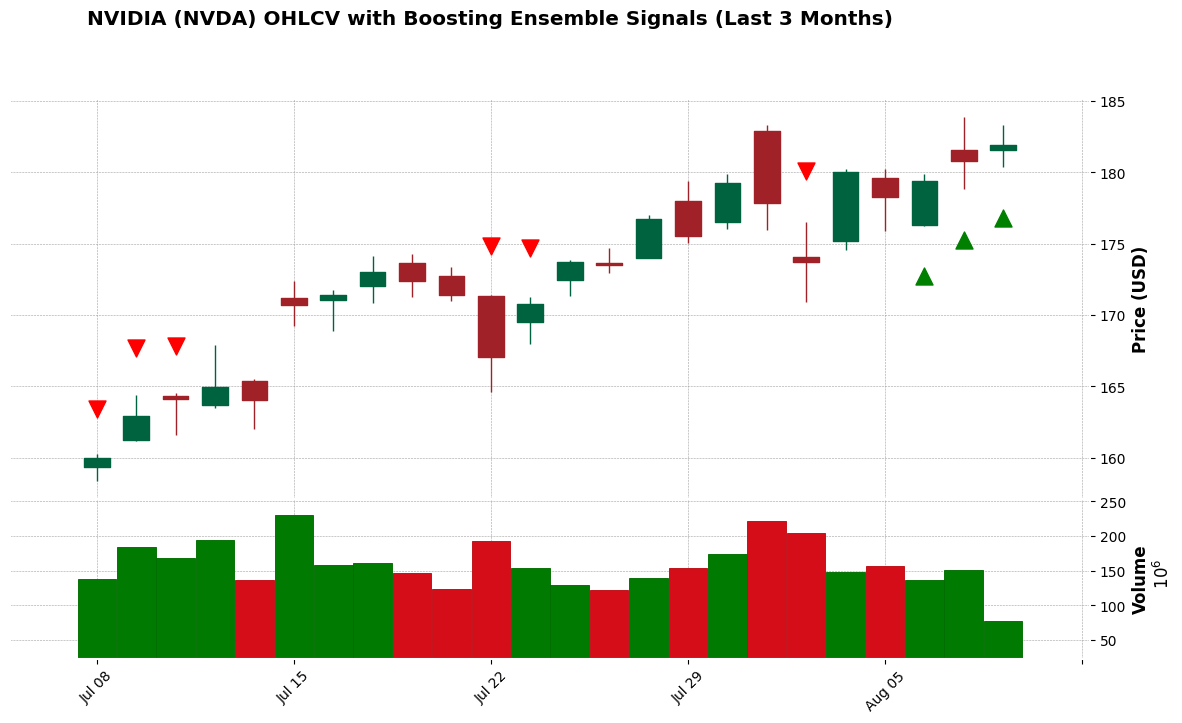

In [9]:
import pandas as pd
import yfinance as yf
import numpy as np
import mplfinance as mpf

# --- Indicator Calculation Functions ---

def calculate_adx(high, low, close, window=4):
    """Calculates the 4-day ADX, +DI, and -DI."""
    tr1 = high - low
    tr2 = abs(high - close.shift(1))
    tr3 = abs(low - close.shift(1))
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    atr = tr.ewm(alpha=1/window, adjust=False).mean()

    plus_dm = high.diff()
    minus_dm = low.diff().mul(-1)
    plus_dm[(plus_dm < 0) | (plus_dm <= minus_dm)] = 0
    minus_dm[(minus_dm < 0) | (minus_dm <= plus_dm)] = 0
    
    plus_di = 100 * plus_dm.ewm(alpha=1/window, adjust=False).mean() / atr
    minus_di = 100 * minus_dm.ewm(alpha=1/window, adjust=False).mean() / atr

    dx = 100 * (abs(plus_di - minus_di) / (plus_di + minus_di))
    adx = dx.ewm(alpha=1/window, adjust=False).mean()
    
    return pd.DataFrame({'ADX': adx, '+DI': plus_di, '-DI': minus_di})

def calculate_rsi(data, window=4):
    """Calculates the 4-day RSI."""
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)
    avg_gain = gain.ewm(com=window - 1, min_periods=window).mean()
    avg_loss = loss.ewm(com=window - 1, min_periods=window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_parabolic_sar(high, low, initial_af=0.02, max_af=0.2):
    """Calculates the Parabolic SAR."""
    length = len(high)
    psar = [np.nan] * length
    bullish = True
    af = initial_af
    ep = high.iloc[0]
    psar[0] = low.iloc[0]

    for i in range(1, length):
        if bullish:
            psar[i] = psar[i-1] + af * (ep - psar[i-1])
        else:
            psar[i] = psar[i-1] - af * (abs(ep - psar[i-1]))

        reverse = False
        if bullish and low.iloc[i] < psar[i]:
            bullish, reverse = False, True
            psar[i], ep, af = ep, low.iloc[i], initial_af
        elif not bullish and high.iloc[i] > psar[i]:
            bullish, reverse = True, True
            psar[i], ep, af = ep, high.iloc[i], initial_af

        if not reverse:
            if bullish and high.iloc[i] > ep:
                ep, af = high.iloc[i], min(af + initial_af, max_af)
            elif not bullish and low.iloc[i] < ep:
                ep, af = low.iloc[i], min(af + initial_af, max_af)
        
        if bullish:
            psar[i] = min(psar[i], low.iloc[i-1], low.iloc[i] if i > 0 else low.iloc[i])
        else:
            psar[i] = max(psar[i], high.iloc[i-1], high.iloc[i] if i > 0 else high.iloc[i])
            
    return pd.Series(psar, index=high.index)


#==================================================================================================================================
# --- 1. Data Fetching ---
# Fetch data for the last 3 months, plus extra for the 66-day MA to initialize
nvda_data = yf.download('NVDA', period="1mo", interval="1d")


    
if isinstance(nvda_data.columns, pd.MultiIndex):
        # Option A – drop the outer level (works when only one ticker):
    nvda_data = nvda_data.droplevel(1, axis=1)

# --- 2. Indicator Calculation ---
nvda_data['MA10'] = nvda_data['Close'].rolling(window=10).mean()
nvda_data['MA22'] = nvda_data['Close'].rolling(window=22).mean()
nvda_data['MA66'] = nvda_data['Close'].rolling(window=66).mean()
nvda_data['RSI4'] = calculate_rsi(nvda_data['Close'], window=4)
nvda_data['PSAR'] = calculate_parabolic_sar(nvda_data['High'], nvda_data['Low'])
adx_data = calculate_adx(nvda_data['High'], nvda_data['Low'], nvda_data['Close'], window=4)
nvda_data = nvda_data.join(adx_data)

# --- 3. Boosting (Weighted Voting) Signal Generation ---
# Define weights for each indicator's vote
weights = {
    'MA66': 2.0,   # Long-term trend: Highest weight
    'MA22': 1.5,   # Medium-term trend: High weight
    'ADX':  1.5,   # Trend strength: High weight
    'MA10': 1.0,   # Short-term trend: Standard weight
    'PSAR': 1.0,   # Short-term trend: Standard weight
    'RSI4': 1.0    # Short-term momentum: Standard weight
}
total_weight = sum(weights.values())

# Calculate the weighted score for each day
weighted_score = pd.Series(0.0, index=nvda_data.index)
if not nvda_data.empty:
    weighted_score[nvda_data['Close'] > nvda_data['MA66']] += weights['MA66']
    weighted_score[nvda_data['Close'] > nvda_data['MA22']] += weights['MA22']
    weighted_score[nvda_data['Close'] > nvda_data['MA10']] += weights['MA10']
    weighted_score[nvda_data['RSI4'] > 50] += weights['RSI4'] # Use > 50 for bullish momentum
    weighted_score[nvda_data['Close'] > nvda_data['PSAR']] += weights['PSAR']
    weighted_score[(nvda_data['+DI'] > nvda_data['-DI']) & (nvda_data['ADX'] > 25)] += weights['ADX']

nvda_data['Weighted_Score'] = weighted_score

# Generate final signal based on the weighted score
# Buy if the score is > 60% of total possible weight
# Sell if the score is < 40% of total possible weight
nvda_data['Signal'] = 0
nvda_data.loc[weighted_score > total_weight * 0.6, 'Signal'] = 1  # Buy Signal
nvda_data.loc[weighted_score < total_weight * 0.4, 'Signal'] = -1 # Sell Signal

# --- 4. Final Day Analysis Text Output ---
last_day = nvda_data.iloc[-1]
print("---" * 15)
print(f"Boosting Ensemble Analysis for NVDA on {last_day.name.date()}")
print("---" * 15)

# Individual Indicator Signals and their contribution
ma66_signal = "Bullish" if last_day['Close'] > last_day['MA66'] else "Bearish"
ma22_signal = "Bullish" if last_day['Close'] > last_day['MA22'] else "Bearish"
ma10_signal = "Bullish" if last_day['Close'] > last_day['MA10'] else "Bearish"
rsi_signal = "Bullish (Momentum > 50)" if last_day['RSI4'] > 50 else "Bearish (Momentum < 50)"
psar_signal = "Bullish" if last_day['Close'] > last_day['PSAR'] else "Bearish"
adx_signal = "Bullish" if (last_day['+DI'] > last_day['-DI']) and (last_day['ADX'] > 25) else "Bearish/Weak"

print(f"Indicator                    | Signal                    | Weight")
print("-----------------------------|---------------------------|---------")
print(f"66-Day Moving Average        | {ma66_signal:<25} | {weights['MA66']}")
print(f"22-Day Moving Average        | {ma22_signal:<25} | {weights['MA22']}")
print(f"ADX (4-Day) Trend            | {adx_signal:<25} | {weights['ADX']}")
print(f"10-Day Moving Average        | {ma10_signal:<25} | {weights['MA10']}")
print(f"Parabolic SAR                | {psar_signal:<25} | {weights['PSAR']}")
print(f"4-Day RSI Momentum           | {rsi_signal:<25} | {weights['RSI4']}")
print("---" * 15)

# Final Ensemble Signal
final_signal_text = "NEUTRAL"
if last_day['Signal'] == 1:
    final_signal_text = "BULLISH"
elif last_day['Signal'] == -1:
    final_signal_text = "BEARISH"

print(f"Total Weighted Bullish Score: {last_day['Weighted_Score']:.2f} / {total_weight:.2f}")
print(f"FINAL BOOSTED SIGNAL: {final_signal_text}")
print("---" * 15)

# --- 5. Simplified Visualization ---
# Focus on the last 3 months for the chart
chart_data = nvda_data.last("3M")

add_plots = []
# Prepare scatter plot data for buy/sell signals
# Add a check to see if there are any signals to plot to avoid the error
if chart_data['Signal'].eq(1).any():
    buy_markers = np.where(chart_data['Signal'] == 1, chart_data['Low'] * 0.98, np.nan)
    add_plots.append(mpf.make_addplot(buy_markers, type='scatter', marker='^', color='green', markersize=150))
else:
    print("No 'Buy' signals generated in the last 3 months.")

if chart_data['Signal'].eq(-1).any():
    sell_markers = np.where(chart_data['Signal'] == -1, chart_data['High'] * 1.02, np.nan)
    add_plots.append(mpf.make_addplot(sell_markers, type='scatter', marker='v', color='red', markersize=150))
else:
    print("No 'Sell' signals generated in the last 3 months.")

# Create the candlestick chart with volume and signals
mpf.plot(chart_data, 
         type='candle', 
         style='charles', 
         title='NVIDIA (NVDA) OHLCV with Boosting Ensemble Signals (Last 3 Months)',
         ylabel='Price (USD)',
         volume=True,
         ylabel_lower='Volume',
         addplot=add_plots if add_plots else None, # Pass None if add_plots is empty
         figsize=(15, 8))
